# Model Explanation with Shapley Values:
Shapley values can be computed within DMLC XGBOOST (https://medium.com/rapids-ai/gpu-accelerated-shap-values-with-xgboost-1-3-and-rapids-587fad6822). 

In [1]:
import os
import sys
import re
import json
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from time import time
from functools import reduce

# import matplotlib.pyplot as plt
import bokeh as bk
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
output_notebook()

import dask
import dask.dataframe as dd
import dask.bag as db
from dask.distributed import Client, progress
from datetime import datetime

import shap
import sklearn
import xgboost as xgb


max_depth = 15
run_type = 'gpu' # Select 'cpu' or 'gpu'
compute_strategy = 'node' # Select 'node' or 'cluster'. Data larger than single GPU requires 'cluster' compute_strategy.

study_arpt = 'NAS'

if study_arpt == 'NAS':
    # NAS processing excludes weather. Has additional cols for arrival/departure airports.
    pred_model = 'multi_class'
    label_col = 'DELAY_CAUSES_ENC'
    delay_causes_cols = ['LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY', 'NAS_DELAY', 'OTHER_DELAY']
    excluded_features = [label_col, 'cv_idx', 'class_weight', 'UID', 'ARR_DEL15', 'DEP_DEL15']
    target_encode_cols = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'OD_PAIR', 'HOLIDAY_NAME', 'TAIL_NUM', 
                          'ORIGIN_HourlyPresentWeatherTypeCombo', 'DEST_HourlyPresentWeatherTypeCombo']
else:
    pred_model = 'binary_class'
    label_col = 'ARR_DEL15'
    excluded_features = [label_col, 'cv_idx', 'UID', 'DEL_ARR_PER_QTHR', 'DEL_DEP_PER_QTHR', 'DEP_DEL15']
    target_encode_cols = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'HOLIDAY_NAME', 'HourlyPresentWeatherTypeCombo']

enc_output_dir = './data/encoded/split/'+study_arpt+'/test' # Can compute Shapley values off of test data.
# model_file = 'xgb_'+run_type+'_airline_delay_'+study_arpt
model_file = 'xgb_'+run_type+'_airline_delay_'+study_arpt+'_max_depth_'+str(max_depth) # Only CPU model ran successfully. Need more than 16GB VRAM or gpu cluster to complete.

# client = Client('tcp://192.168.1.232:8786')

if run_type == 'gpu':
    from dask_cuda import LocalCUDACluster
    
    cluster = LocalCUDACluster(threads_per_worker=16, memory_limit='128GB')
    client = Client(cluster)
#     client = Client(n_workers=1, threads_per_worker=32)
elif run_type == 'cpu':
#     client = Client(n_workers=1, threads_per_worker=32)
    client = Client(n_workers=2, threads_per_worker=16, memory_limit='128GB')
    
client

Loading BokehJS ...

distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 32,Total memory: 238.42 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36499,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 238.42 GiB
Comm: tcp://127.0.0.1:46717,Total threads: 16
Dashboard: http://127.0.0.1:42779/status,Memory: 119.21 GiB
Nanny: tcp://127.0.0.1:45077,


In [2]:
if compute_strategy == 'node':
    if run_type == 'gpu':
        import cudf as hw
    else:
        import pandas as hw
elif compute_strategy == 'cluster':
    if run_type == 'gpu':
        import dask_cudf as hw
    else:
        import dask.dataframe as hw
    
# Run predictions:
method = 'xgb_' + run_type
data_path = enc_output_dir
model = xgb.Booster(model_file=model_file+'.model')
model.set_param('predictor', run_type+'_predictor')
# model = client.scatter(model, broadcast=True) # Pre scattering model can improve performance

tic = time()
if (method == 'xgb_gpu') | (method == 'xgb_cpu'):
    method_type = method.split('_')[1]
    
    # ddf_enc = hw.read_parquet(data_path) # Load all data
    ddf_enc = hw.read_parquet(data_path).sample(frac=0.1, random_state=0) # Random resampling
#     ddf_enc = hw.read_parquet(data_path).iloc[:int(7E4)]
    print('Number of records in input data:', len(ddf_enc))
    
    # Format data for xgboost training:
    feature_cols = [cc for cc in ddf_enc.columns if cc not in excluded_features]
#     print(feature_cols)
    
    # Update bool cols:
    bool_cols = list(ddf_enc.select_dtypes(bool).columns)
    ddf_enc[bool_cols] = ddf_enc[bool_cols].astype('int8')
    
    X = ddf_enc[feature_cols].astype('float32')
    y = ddf_enc[label_col].astype('float32')

    if compute_strategy == 'node':
        shap_values = model.predict(xgb.DMatrix(X, y), pred_contribs=True)
    elif compute_strategy == 'cluster':
        shap_values = xgb.dask.predict(client, model, xgb.dask.DaskDMatrix(client, X, y), pred_contribs=True)

        # IMPORTANT: X.values required to get consistent CPU scoring. Issue with column ordering in dask.dataframe?
#         shap_values = xgb.dask.predict(client, model, X.values, pred_contribs=True) # Use pred_contribs not available in inplace_predict()
        
        shap_values = shap_values.compute()
        
    # Some cols are removed during model encoding and/or feature engineering. 
    print('Shape of shap_values:', shap_values.shape)
    print('Number of features:', len(feature_cols))

if pred_model == 'binary_class':
    shap_expected_values = shap_values[:,-1]
    shap_values = shap_values[:,:-1]
elif pred_model == 'multi_class':
    shap_expected_values = shap_values[:,:,-1]
    shap_values = shap_values[:,:,:-1]


# Note that XGB shap computation has an extra column appended. "The last column in the output shap_values contains the ‘bias’ or the expected output of the model if no features were used."
# Since we will be using the python shap package to visualize results, it's safe to drop the last column for compatibility.
# pred_contribs (bool) – When this is True the output will be a matrix of size (nsample, nfeats + 1) with each record indicating the feature contributions (SHAP values) for that prediction. 
# The sum of all feature contributions is equal to the raw untransformed margin value of the prediction. Note the final column is the bias term.

print('xgboost shap_values computation time:', '{:0.2f}'.format(time() - tic) + 's')


# Shapley value for multi-class problem uses a lot of mem. Maybe it's running all classes simultaneously with copies of the data?
# Much more expensive to compute for deep tree models. 

# Use training set and randomly sample 70k (frac=0.01) or 700k (frac=0.1) records:
# 70k samples on 1x RTX8000 GPU: 5-depth took 8s, 10-depth took 76s, 15-depth took 195s.
# 700k samples on 1x RTX8000 GPU: 5-depth took 23s, 10-depth took 589s, 15-depth took 1647s.
# 700k samples on 2x RTX8000 GPU: 5-depth took 15s, 10-depth took 311s, 15-depth took 856s.

# 70k samples on 32-core CPU: 5-depth took 15s, 10-depth took 395s, 15-depth took 1100.77s.
# 700k samples on 32-core CPU: 5-depth took 91s, 10-depth took 3879s, 15-depth took ---.

# TODO: MNMG wrapper for multi-class shapley value cuml.explainer.PermutationExplainer (based on SHAP Kernel Explainer). Use dask.predict() for now.
# Need One-vs-One training implementation to reduce memory usage and compute during training and shapley value computation. 

Number of records in input data: 54554
Shape of shap_values: (54554, 9, 141)
Number of features: 140
xgboost shap_values computation time: 40.09s


In [3]:
# Convert dask.dataframe, cudf, etc. to pandas:
if compute_strategy == 'node':
    if run_type == 'gpu':
        pd_enc = ddf_enc.to_pandas()
    else:
        pd_enc = ddf_enc
elif compute_strategy == 'cluster':
    if run_type == 'gpu':
        pd_enc = ddf_enc.compute().to_pandas()
    else:
        pd_enc = ddf_enc.compute()
        
# Reset index for resampling with iloc later on:
pd_enc = pd_enc.reset_index(drop=True)

X_cmp = pd_enc[feature_cols]
y_cmp = pd_enc[label_col]

In [4]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Convert logit from "raw" output of shap_values to probabilities:    
y_logit = shap_values.sum(axis=2) + shap_expected_values
y_odds = np.exp(y_logit)
y_proba = y_odds / (1 + y_odds)

# Determine most likely class based on individual binary predictions:
y_proba_class = np.argmax(y_proba, axis=1)

num_classes = int(np.max(y)+1)

meta_class_cnts = pd.read_csv('./data/staging_tbl/class_labels.csv')

# Truncate at last class:
meta_class_cnts = meta_class_cnts[:num_classes]
class_labels = list(meta_class_cnts['CLASS_STR'].values)
class_labels = class_labels[:-1] + ['OOOO']

# Use appropriate metrics for evaluating multi-class predictions.
print(classification_report(y_cmp, y_proba_class, target_names=class_labels))

# F1 score = 2*(precision*recall)/(precision + recall)

# Compute confusion matrix:
cf_matrix = confusion_matrix(y_cmp, y_proba_class)

              precision    recall  f1-score   support

        ----       1.00      1.00      1.00     49316
        -C--       0.44      0.74      0.55      1304
        --N-       0.92      0.78      0.84      1142
        -CN-       0.49      0.65      0.56       582
        L---       0.32      0.21      0.25       540
        LC--       0.43      0.37      0.40       774
        L-N-       0.32      0.07      0.11       316
        LCN-       0.35      0.13      0.19       291
        OOOO       0.39      0.17      0.24       289

    accuracy                           0.95     54554
   macro avg       0.52      0.46      0.46     54554
weighted avg       0.95      0.95      0.95     54554



The sample data included are insufficient to draw any conclusions. A more detailed analysis against a larger dataset is provided in the blog post [insert link]. 

For now, we can focus on explaining predictions for carrier delays ["-C--"], which has the highest accuracy score among the minority flight delay causes observed in the full dataset. We can do this because the OVR decomposition treats each sub-class as its own binary classification problem. Based on the confusion matrix, the model seems to have difficultly in distinguishing other minority classes, especially when multiple delay causes are present. By combining several classes together, better prediction accuracy can be achieved. This would require modifying the ETL stages for the flight tables to update delay cause definitions, retraining the models, and then interpreting the results once more.

Text(84.5, 0.5, 'Actual')

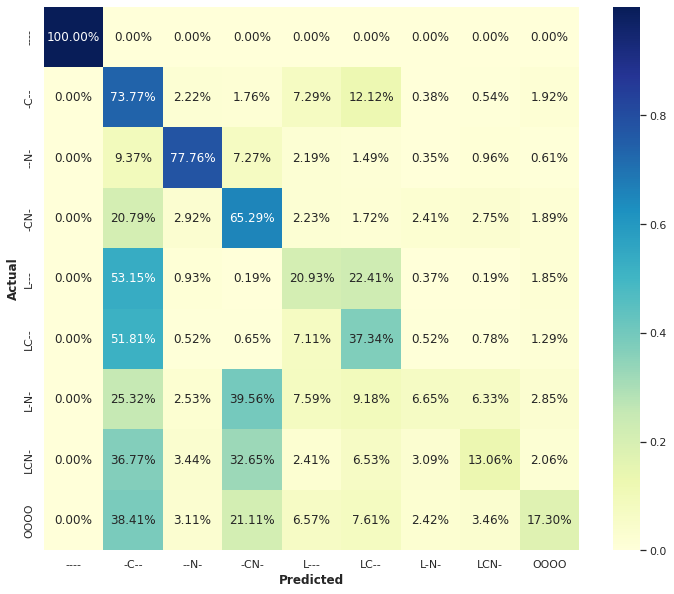

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12, 10)})

# Applying normalize param in sklearn.metrics.confusion_matrix results in 
# normalize='pred': precision along main diag. Matrix column sums to 1.  
# normalize='true': recall along the main diag. Matrix row sums to 1.
cf_matrix = confusion_matrix(y_cmp, y_proba_class, normalize='true')

sns.heatmap(cf_matrix, annot=True, fmt='.2%', cmap='YlGnBu',
           xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted', fontsize=12, weight='bold')
plt.ylabel('Actual', fontsize=12, weight='bold')

In [6]:
# Consolidate labels into broader categories:
wx_attr = ['HourlyDryBulbTemperature', 'HourlyPrecipitation', 'HourlyPressureChange', 'HourlyVisibility',
           'HourlyWindDirection_sin', 'HourlyWindDirection_cos', 
           'HourlyWindGustSpeed', 'HourlyWindSpeed', 'HourlySkyCover_BKN', 'HourlySkyCover_FEW', 'HourlySkyCover_OVC',
           'HourlySkyCover_SCT', 'HourlySkyCover_VV', 'HourlyPresentWeatherTypeCombo']
wx_attr = [prefix+cc for prefix in ['ORIGIN_', 'DEST_'] for cc in wx_attr]

seasons_attr = ['QUARTER', 'MONTH', 'DAY_OF_YEAR', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME_HR', 
                'CRS_DEP_TIME_QTHR', 'CRS_ARR_TIME_HR', 'CRS_ARR_TIME_QTHR']
seasons_attr = [cc+suffix for suffix in ['_sin', '_cos'] for cc in seasons_attr] + ['YEAR', 'HOLIDAY_NAME', 'IS_HOLIDAY', 'IS_WEEKEND']

combine_labels = {
    'ARPT_ATTR': [cc for cc in feature_cols if cc.find('ARPT')!=-1],
    'SEASON_ATTR': seasons_attr,
    'DEMAND_ATTR': ['ORIGIN_ARR_PER_QTHR', 'ORIGIN_CRS_ARR_PER_QTHR', 'ORIGIN_DEL_ARR_PER_QTHR', 'ORIGIN_ARR_DIFF0_PER_QTHR', 
                    'ORIGIN_ARR_PER_QTHR_LAG30', 'ORIGIN_CRS_ARR_PER_QTHR_LAG30', 'ORIGIN_DEL_ARR_PER_QTHR_LAG30', 
                    'ORIGIN_ARR_DIFF0_PER_QTHR_LAG30', 'ORIGIN_ARR_PER_QTHR_LAG15', 'ORIGIN_CRS_ARR_PER_QTHR_LAG15', 
                    'ORIGIN_DEL_ARR_PER_QTHR_LAG15', 'ORIGIN_ARR_DIFF0_PER_QTHR_LAG15', 'ORIGIN_CRS_ARR_PER_QTHR_LEAD15', 
                    'ORIGIN_CRS_ARR_PER_QTHR_LEAD30', 'ORIGIN_ARR_DIFF1_PER_QTHR', 'ORIGIN_ARR_DIFF2_PER_QTHR', 'ORIGIN_DEP_PER_QTHR', 
                    'ORIGIN_CRS_DEP_PER_QTHR', 'ORIGIN_DEL_DEP_PER_QTHR', 'ORIGIN_DEP_DIFF0_PER_QTHR', 'ORIGIN_DEP_PER_QTHR_LAG30', 
                    'ORIGIN_CRS_DEP_PER_QTHR_LAG30', 'ORIGIN_DEL_DEP_PER_QTHR_LAG30', 'ORIGIN_DEP_DIFF0_PER_QTHR_LAG30', 
                    'ORIGIN_DEP_PER_QTHR_LAG15', 'ORIGIN_CRS_DEP_PER_QTHR_LAG15', 'ORIGIN_DEL_DEP_PER_QTHR_LAG15', 
                    'ORIGIN_DEP_DIFF0_PER_QTHR_LAG15', 'ORIGIN_CRS_DEP_PER_QTHR_LEAD15', 'ORIGIN_CRS_DEP_PER_QTHR_LEAD30', 
                    'ORIGIN_DEP_DIFF1_PER_QTHR', 'ORIGIN_DEP_DIFF2_PER_QTHR', 'DEST_ARR_PER_QTHR', 'DEST_CRS_ARR_PER_QTHR', 
                    'DEST_DEL_ARR_PER_QTHR', 'DEST_ARR_DIFF0_PER_QTHR', 'DEST_ARR_PER_QTHR_LAG30', 'DEST_CRS_ARR_PER_QTHR_LAG30', 
                    'DEST_DEL_ARR_PER_QTHR_LAG30', 'DEST_ARR_DIFF0_PER_QTHR_LAG30', 'DEST_ARR_PER_QTHR_LAG15', 
                    'DEST_CRS_ARR_PER_QTHR_LAG15', 'DEST_DEL_ARR_PER_QTHR_LAG15', 'DEST_ARR_DIFF0_PER_QTHR_LAG15', 
                    'DEST_CRS_ARR_PER_QTHR_LEAD15', 'DEST_CRS_ARR_PER_QTHR_LEAD30', 'DEST_ARR_DIFF1_PER_QTHR', 
                    'DEST_ARR_DIFF2_PER_QTHR', 'DEST_DEP_PER_QTHR', 'DEST_CRS_DEP_PER_QTHR', 'DEST_DEL_DEP_PER_QTHR', 
                    'DEST_DEP_DIFF0_PER_QTHR', 'DEST_DEP_PER_QTHR_LAG30', 'DEST_CRS_DEP_PER_QTHR_LAG30', 
                    'DEST_DEL_DEP_PER_QTHR_LAG30', 'DEST_DEP_DIFF0_PER_QTHR_LAG30', 'DEST_DEP_PER_QTHR_LAG15', 
                    'DEST_CRS_DEP_PER_QTHR_LAG15', 'DEST_DEL_DEP_PER_QTHR_LAG15', 'DEST_DEP_DIFF0_PER_QTHR_LAG15', 
                    'DEST_CRS_DEP_PER_QTHR_LEAD15', 'DEST_CRS_DEP_PER_QTHR_LEAD30', 'DEST_DEP_DIFF1_PER_QTHR', 'DEST_DEP_DIFF2_PER_QTHR'],
    'WEATHER_ATTR': wx_attr
}

In [7]:
max_display = 11
combine_attr = True # Combine features to decrease number of attributes

# Load class labels:
num_classes = int(np.max(y)+1)
meta_class_cnts = pd.read_csv('./data/staging_tbl/class_labels.csv')

# Truncate at last class:
meta_class_cnts = meta_class_cnts[:num_classes]
class_labels = list(meta_class_cnts['CLASS_STR'].values)
class_labels = class_labels[:-1] + ['OOOO']


shap_imp_by_class = pd.DataFrame(np.abs(shap_values).mean(axis=0), columns=feature_cols)
# shap_imp_by_class['CLASS'] = ['CLASS_' + str(ii) for ii in range(shap_values.shape[1])]
shap_imp_by_class['CLASS'] = class_labels
shap_imp_by_class = shap_imp_by_class.set_index('CLASS')

if combine_attr == True:
    # Use combine_labels to combine Shapley values for each attribute group.
    combine_labels_vals = reduce(lambda x,y: x+y, list(combine_labels.values()))
    remaining_cols = list(set(feature_cols) - set(combine_labels_vals))
    shap_imp_combo_attr = shap_imp_by_class[remaining_cols].copy()

    for kk in combine_labels.keys():
        shap_imp_combo_attr.loc[:, kk] = shap_imp_by_class[combine_labels[kk]].sum(axis=1).values
        
    shap_imp_by_class = shap_imp_combo_attr

    
sorted_feature_imp = list(shap_imp_by_class.sum().sort_values(ascending=False).index)

shap_imp_by_class = shap_imp_by_class[sorted_feature_imp].reset_index()
shap_imp_by_class

,CLASS,DEP_DELAY,ARR_DELAY,DEMAND_ATTR,SEASON_ATTR,WEATHER_ATTR,OP_UNIQUE_CARRIER,TAXI_OUT,ARPT_ATTR,OD_PAIR,TAIL_NUM,ACTUAL_ELAPSED_TIME,CRS_ELAPSED_TIME,TAXI_IN,ORIGIN,DEST,AIR_TIME,DISTANCE,DISTANCE_GROUP
0,----,0.015696,10.517841,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-C--,2.741561,0.942718,0.562756,0.368828,0.298901,0.476043,0.083865,0.152000,0.292961,0.281935,0.028994,0.031656,0.031507,0.035684,0.023523,0.013067,0.009213,0.000064
2,--N-,2.063992,4.368607,0.474979,0.414930,0.270407,0.434010,0.050691,0.136353,0.049624,0.167279,0.014382,0.008506,0.051032,0.027736,0.062353,0.017004,0.024360,0.000065
3,-CN-,2.291535,1.723984,0.470280,0.156988,0.232515,0.126674,0.159452,0.133852,0.050049,0.050574,0.274430,0.135900,0.010673,0.010057,0.017600,0.052220,0.010240,0.000099
4,L---,3.701755,0.174870,0.942181,0.262804,0.278011,0.427137,0.176608,0.145468,0.036052,0.093503,0.158527,0.068839,0.028785,0.027430,0.032661,0.027305,0.021784,0.000389
5,LC--,4.579667,0.211254,0.527292,0.348407,0.255761,0.354083,0.199637,0.110133,0.070429,0.084535,0.061873,0.049165,0.033714,0.020624,0.022880,0.017350,0.024119,0.000731
6,L-N-,1.909132,0.478626,1.008399,0.504606,0.363479,0.185376,0.275920,0.164399,0.108121,0.126175,0.158434,0.095118,0.099536,0.019910,0.033602,0.039956,0.029571,0.000500
7,LCN-,1.897850,0.607976,0.809999,0.502928,0.324648,0.366161,0.158310,0.183122,0.249865,0.140834,0.205087,0.071585,0.077800,0.037440,0.018914,0.023778,0.030755,0.000266
8,OOOO,1.443060,0.547037,0.775184,0.438991,0.952111,0.201932,0.273033,0.209290,0.251368,0.101219,0.015066,0.012918,0.020279,0.104499,0.042565,0.012674,0.014655,0.000233


In [8]:
from bokeh.models import Legend

p = figure(plot_height=500, plot_width=800, y_range=list(shap_imp_by_class['CLASS']), x_range=(0,18), 
            title='Shapley Global Feature Importance', 
           toolbar_location=None, tools='hover', tooltips='$name: @$name'
           )

# TODO: more granular ranking within each class, then get rank overall. Some ideas: https://towardsdatascience.com/rank-the-features-now-rank-again-4dafd8cde3c8
# Within each class, rank features by order of Shapley importance. Then sum results overall to get ranking as a whole for plotting.
# rank_class_ii = shap_imp_by_class.loc[5, feature_cols].sort_values(ascending=False)
# Plot each column separately so that features can be plotted by rank?

# Pick top (max_dislay-1) features based on overall ranking for now.
feature_subset = sorted_feature_imp[:max_display-1]
other_features = list(set(list(shap_imp_by_class.columns.difference(['CLASS']))) - set(feature_subset))

# Create an "OTHER" column to consolidate remaining features:
shap_imp_by_class_sm = shap_imp_by_class[['CLASS']+feature_subset].copy()
shap_imp_by_class_sm['OTHER'] = shap_imp_by_class[other_features].sum(axis=1)

p.hbar_stack(feature_subset+['OTHER'], y='CLASS', height=0.9, 
             color=bk.palettes.Category20[max_display], source=shap_imp_by_class_sm,
             legend_label=feature_subset+['OTHER']
            )

p.xaxis.axis_label = 'mean(|SHAP value|)'
p.add_layout(Legend(), 'below')
# p.add_layout(Legend(), 'left')
# p.legend.location = 'top_left'
p.legend.click_policy = 'hide'

# Legend location with bokeh hbar_stack not being positioned outside plot. Use x_range option for now.
show(p)

In [9]:
# Possible use case: embedding Shapley values, dimensionality reduction, clustering.
# Ranking can get complicated: https://towardsdatascience.com/rank-the-features-now-rank-again-4dafd8cde3c8.
# Use cross-validation to examine feature importance across folds. Check for stability, and help with feature down-selection/generalize model.
# Basically a guided search of the feature-space rather than randomly permutting features to see what works well.

In [10]:
%%time

# # Compute shap values using shap package and externally trained model:
# explainer = shap.Explainer(model) # Including X as second arg forces shap to recompute it. May result in different shap values since new model generated.
# shap_exp_obj = explainer(X_cmp)

# shap package explainer class uses attributes like .values (shap_values), .base_values 
# (shap_expected_values), and .data (X, feature matrix). Should reuse them to make xgb computation compatible.

# Create shap explainer object:
explainer = shap.TreeExplainer(model)
shap_exp_obj = explainer(X_cmp.iloc[:2,]) # Construct as place holder class from 2 rows of data.

# Populate Explainer object with shap attributes computed from xgb.
shap_exp_obj.values = shap_values
shap_exp_obj.base_values = shap_expected_values
shap_exp_obj.data = X_cmp.values

# # Clean up:
# del shap_values, shap_expected_values

CPU times: user 16.1 s, sys: 416 ms, total: 16.5 s
Wall time: 7.89 s


In [11]:
# shap python package has more extensive visualization capabilities built-in. But it doesn't recognize dask/cudf dataframes.
# Gather dask dataframes to pandas after using dask+xgb to distributively compute shap_values. 

# load JS visualization code to notebook
shap.initjs()

# Examine explanation for single observation:
row_num = 11
class_num = 2

print('Actual class:', class_labels[y_cmp.iloc[row_num]])

# shap.force_plot(explainer.expected_value, py_shap_values[row_num,:], X_pd.iloc[row_num,:]) # Shap values from pandas + shap package
# shap.force_plot(shap_expected_values[row_num], shap_values[row_num,:], X_cmp.iloc[row_num,:]) # Shap values from dask + xgb package

# shap.force_plot() with multi-class stacked bar-chart styling.

# for class_num in range(num_classes):
print('Force plot for class:', class_labels[class_num])

# Use link='logit' to obtain probability scaling on force_plot
shap.plots.force(explainer.expected_value[class_num], shap_exp_obj.values[row_num][class_num], X_cmp.iloc[row_num,:], feature_names=feature_cols, link='logit')

# shap values add up to logit instead of probab [0 <= y_pred <=1]. 

# TODO: iterate through each class to plot individual class force_plot in pred_model='multi_class' case.

Actual class: ----
Force plot for class: --N-


In [12]:
# Balanced sampling based on label:
from sklearn.model_selection import train_test_split

n_samples = 500
train_idx, test_idx = train_test_split(np.arange(len(pd_enc)), train_size=n_samples/len(pd_enc), stratify=pd_enc[label_col], random_state=0)

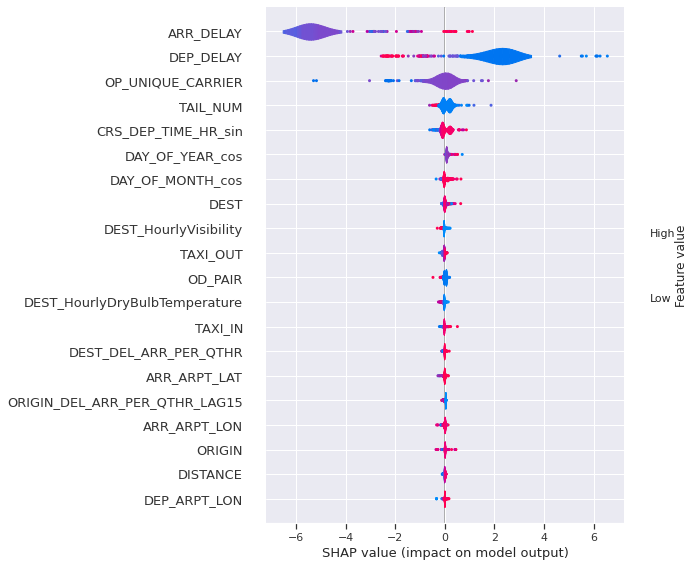

In [14]:
# Density plot for n_samples, given a particular class:
sel_class = 2 # Select class index to display violin plot.

if pred_model == 'multi_class':
    shap_value_slice = shap_values[train_idx, sel_class, :]
else:
    shap_value_slice = shap_values[train_idx, :]

shap.summary_plot(shap_value_slice, features=X_cmp.iloc[train_idx, :], plot_type='violin')